# 01b_embedding_autoencoder

In this notebook, an autoencoder is trained on our training data textual description embeddings, reducing the embeddings to a bottlenecked 2-dimenstion latent space.

The purpose of this will be convert our textual project descriptions to two additional features we can use while training and testing our model.

In [1]:
random_seed = 109

from numpy.random import seed
seed(random_seed)

import tensorflow as tf
tf.random.set_seed(random_seed)

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot
import matplotlib.pylab as plt 
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam, SGD

In [3]:
filepath_embed = '../data/interim/embeddings_uncased_L-2_H-128_A-2.csv'
filepath_train = '../data/interim/NYC_capital_projects_3yr_train.csv'
filepath_test = '../data/interim/NYC_capital_projects_3yr_test.csv'

if os.path.isfile(filepath_embed):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [4]:
data_embed = pd.read_csv(filepath_embed)
data_train = pd.read_csv(filepath_train)
data_test = pd.read_csv(filepath_test)

data_full = pd.read_csv('../data/interim/Capital_Projects_clean.csv') 

In [5]:
# entries
print(f"Number of dataset records: {len(data_embed)}")

# num projects
print(f"Number of unique projects in dataset: {len(data_embed['PID'].unique())}")

Number of dataset records: 681
Number of unique projects in dataset: 378


In [6]:
data_embed.info()

data_embed.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 2 columns):
PID          681 non-null int64
embedding    681 non-null object
dtypes: int64(1), object(1)
memory usage: 10.8+ KB


,PID,embedding
0,3,"-0.13848002, 1.4585834, -6.7887063, 0.06124621..."
1,7,"-0.1312232, 1.1953796, -6.7208276, 0.061367474..."
2,18,"0.0988148, 1.6704051, -6.5728025, 0.068978384,..."


In [7]:
# dedupe dataframe by keeping first occurance of each PID
data_embed = data_embed.copy().drop_duplicates(subset='PID', keep='first')

In [8]:
# entries
print(f"Number of dataset records: {len(data_embed)}")

# num projects
print(f"Number of unique projects in dataset: {len(data_embed['PID'].unique())}")

Number of dataset records: 378
Number of unique projects in dataset: 378


In [9]:
# split embedding data into train/test splits

# identify PIDs in train and test sets
train_pids = data_train['PID'].values
test_pids = data_test['PID'].values

# used those PIDs to create two subsetted versions of the embed data
embed_train = data_embed.set_index('PID').copy().loc[train_pids]
embed_test = data_embed.set_index('PID').copy().loc[test_pids]

In [10]:
train_pids.shape, embed_train.shape, test_pids.shape, embed_test.shape

((134,), (134, 1), (15,), (15, 1))

In [11]:
# generate embeddings train and test embedding value arrays

# save index keys for both embedding sets just in case
pid_key_train = data_train['PID'].index
pid_key_test = data_test['PID'].index

# extract embedding values from comma separated strings and convert to matrix 
embed_array_train = np.vstack(
    embed_train['embedding'].str.split(',').apply(
        lambda x: np.array(x).astype(float)
    ).values
)

embed_array_test = np.vstack(
    embed_test['embedding'].str.split(',').apply(
        lambda x: np.array(x).astype(float)
    ).values
)

# check shapes and types of resulting arrays
embed_array_train.shape, embed_array_train.dtype, embed_array_test.shape, embed_array_test.dtype

((134, 512), dtype('float64'), (15, 512), dtype('float64'))

# Define functions for plotting and keras architecture

In [12]:
# define function for plotting train vs val loss history by epoch

def plot_history(history, title, val_name='validation', loss_type='MSE'):
    """Plot training and validation loss using keras history object
    """
    n_epochs = len(history.history['loss'])
    x_vals = np.arange(1, n_epochs+1)
    
    # adjust interval of x_ticks based on n_epochs
    if n_epochs<40:
        x_ticks = x_vals
    elif n_epochs<140:
        x_ticks = np.arange(0, n_epochs+1, 5)
    else:
        x_ticks = np.arange(0, n_epochs+1, 10)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    plt.suptitle('{}'.format(title), fontsize=18)
        
    ax.plot(x_vals, history.history['loss'], 'k--', label='training')
    ax.plot(x_vals, history.history['val_loss'], 'k-', label=val_name)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_ylabel('loss ({})'.format(loss_type), fontsize=14)
    ax.set_xticks(x_ticks)
    ax.grid(':', alpha=0.4)
    ax.tick_params(labelsize=12)        
    
    plt.legend(fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, .9])
    plt.show()

    
def plot_2d_embed_scatter(data1, data2, title, xlabel, ylabel,
                          data1_name='training obs', data2_name='TEST obs'):
    """
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.title(
        title,
        fontsize=18
    )
    plt.scatter(*data1.T,  color='silver', alpha=1, label=data1_name)
    plt.scatter(*data2.T, color='k', alpha=1, label=data2_name)
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(':', alpha=0.4)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    
def plot_1d_embed_hist(data1, data2, title, xlabel, logscale=True,
                       data1_name='training obs', data2_name='TEST obs'):
    """
    """
    fig, ax = plt.subplots(figsize=(12, 4.5))
    plt.title(
        title,
        fontsize=18
    )
    plt.hist(*data1.T, color='silver', alpha=1, label=data1_name)
    plt.hist(*data2.T, color='k', alpha=1, label=data2_name)
    if logscale:
        plt.yscale('log')
        plt.ylabel('frequency (log scale)', fontsize=14)
    else:
        plt.ylabel('frequency', fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.grid(':', alpha=0.4)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

In [13]:
def build_dense_ae_architecture(input_dim, encoding_dim, droprate, learning_rate, name):
    """
    """
    # define encoder model
    input_layer = Input(shape=input_dim)
    encoded = Dense(encoding_dim*256, activation='relu', use_bias=True)(input_layer)
    encoded = Dense(encoding_dim*64, activation='relu', use_bias=True)(encoded)
    encoded = Dropout(rate=droprate)(encoded)
    encoded = Dense(encoding_dim*16, activation='relu', use_bias=True)(encoded)
    encoded = Dropout(rate=droprate)(encoded)
    encoded = Dense(encoding_dim*4, activation='relu', use_bias=True)(encoded)
    encoded = Dropout(rate=droprate)(encoded)
    encoded = Dense(encoding_dim, activation='linear', use_bias=True)(encoded)
    encoder = Model(input_layer, encoded, name='{}_encoder'.format(name))

    # define decoder model
    latent_input = Input(shape=(encoding_dim,))
    decoded = Dense(encoding_dim*4, activation='relu', use_bias=True)(latent_input)
    decoded = Dropout(rate=droprate)(decoded)
    decoded = Dense(encoding_dim*16, activation='relu', use_bias=True)(decoded)
    encoded = Dropout(rate=droprate)(decoded)
    decoded = Dense(encoding_dim*64, activation='relu', use_bias=True)(decoded)
    decoded = Dropout(rate=droprate)(decoded)
    decoded = Dense(encoding_dim*256, activation='relu', use_bias=True)(decoded)
    decoded = Dense(input_dim, activation='linear', use_bias=True)(decoded)
    decoder = Model(latent_input, decoded, name='{}_decoder'.format(name))

    # define full non-linear autoencoder model
    ae = Sequential(
        [
            encoder,
            decoder,
        ], name=name
    )

    # set loss, optimizer, and compile model
    loss = tf.keras.losses.mean_squared_error
    optimizer = Adam(lr=learning_rate)

    ae.compile(
        loss=loss,
        optimizer=optimizer
    )

    return ae, encoder, decoder


# Build and fit Dense Autoencoder with 2D bottleneck


THE ENCODER MODEL:

Model: "ae_2dim_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (

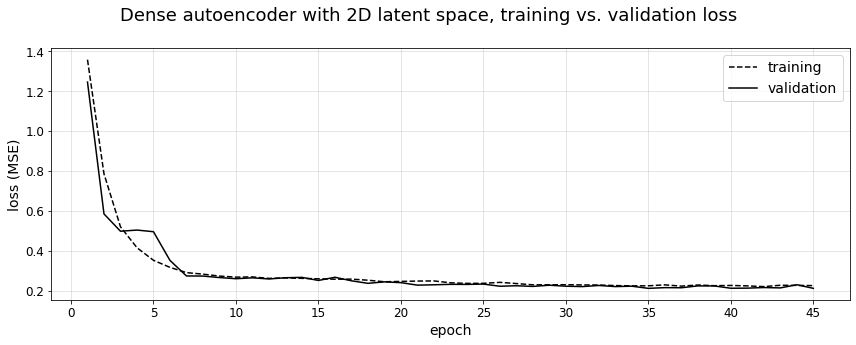

CPU times: user 6.63 s, sys: 1.42 s, total: 8.05 s
Wall time: 8.51 s


In [14]:
%%time

seed(random_seed)
tf.random.set_seed(random_seed)

# set input and encoded latent dimensions
input_dim = embed_array_train.shape[1]
encoding_dim = 2
droprate = 0.2
learning_rate = 0.005
name = 'ae_2dim'

ae2, encoder2, decoder2 = build_dense_ae_architecture(
    input_dim, encoding_dim, droprate, learning_rate, name
)

# print summaries of each model
print('\nTHE ENCODER MODEL:\n')
encoder2.summary()
print('\n\nTHE DECODER MODEL:\n')
decoder2.summary()
print('\n\nTHE AUTOENCODER (AE) MODEL:\n')
ae2.summary()
print('\n')


# set my parameters for training the model
verbose = 0
epochs = 200 # note my use of early-stopping to end training at suitable epoch
batch_size = 16

# callback for early stopping when epochs fail to yield val_loss improvements
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=10, verbose=1,
    restore_best_weights=True
)


# Fit model using x_test as validation data and self for measuring loss
ae2_history = ae2.fit(
    x=embed_array_train,
    y=embed_array_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[callback],
    validation_data=(embed_array_train, embed_array_train),
    verbose=verbose
)

# plot the training vs validation loss 
plot_history(
    ae2_history,
    'Dense autoencoder with 2D latent space, training vs. validation loss',
    loss_type='MSE'
)

# Build and fit Dense Autoencoder with 1D bottleneck


THE ENCODER MODEL:

Model: "ae_1dim_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (

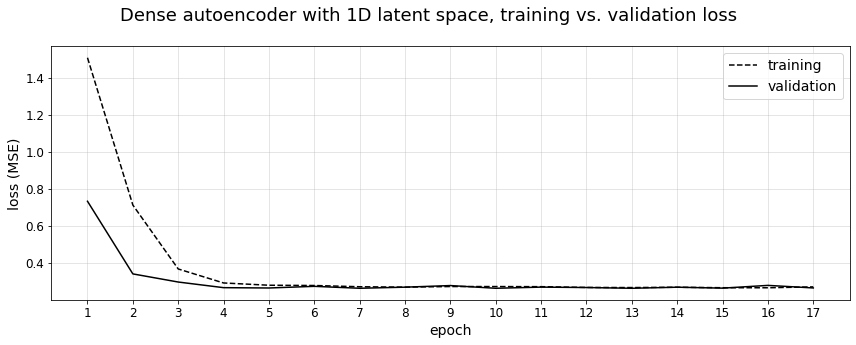

CPU times: user 3.21 s, sys: 178 ms, total: 3.39 s
Wall time: 2.82 s


In [15]:
%%time

seed(random_seed)
tf.random.set_seed(random_seed)

# set input and encoded latent dimensions
input_dim = embed_array_train.shape[1]
encoding_dim = 1
droprate = 0.2
learning_rate = 0.005
name = 'ae_1dim'

ae1, encoder1, decoder1 = build_dense_ae_architecture(
    input_dim, encoding_dim, droprate, learning_rate, name
)

# print summaries of each model
print('\nTHE ENCODER MODEL:\n')
encoder1.summary()
print('\n\nTHE DECODER MODEL:\n')
decoder1.summary()
print('\n\nTHE AUTOENCODER (AE) MODEL:\n')
ae1.summary()
print('\n')

# set my parameters for training the model
verbose = 0
epochs = 200 # note my use of early-stopping to end training at suitable epoch
batch_size = 16

# callback for early stopping when epochs fail to yield val_loss improvements
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=10, verbose=1,
    restore_best_weights=True
)


# Fit model using x_test as validation data and self for measuring loss
ae1_history = ae1.fit(
    x=embed_array_train,
    y=embed_array_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[callback],
    validation_data=(embed_array_train, embed_array_train),
    verbose=verbose
)

# plot the training vs validation loss 
plot_history(
    ae1_history,
    'Dense autoencoder with 1D latent space, training vs. validation loss',
    loss_type='MSE'
)

# Fit PCA decomposition with 2 components

In [16]:
# generate PCA reduction
PCA_embed = PCA(
    n_components=2, random_state=random_seed
).fit(embed_array_train)

pca_expvar = PCA_embed.explained_variance_ratio_
total_expvar = pca_expvar.sum()

print(
    'PCA decomposition fitted on training data embeddings.\n\n'\
    'Total variance explained by the first 2 PCA compoenents: {:.2%}'\
    '\n'.format(total_expvar)
)

PCA decomposition fitted on training data embeddings.

Total variance explained by the first 2 PCA compoenents: 31.27%



## Generate encoded embeddings for Train and Test using each method

In [17]:
# generate AE 2D latent embeddings
ae2_latent_train = encoder2.predict(embed_array_train)
ae2_latent_test = encoder2.predict(embed_array_test)

# generate AE 1D latent embeddings
ae1_latent_train = encoder1.predict(embed_array_train)
ae1_latent_test = encoder1.predict(embed_array_test)

# generate PCA latent embeddings
pca_embed_train = PCA_embed.transform(embed_array_train)
pca_embed_test = PCA_embed.transform(embed_array_test)


# Plot resulting encoded embeddings for each method

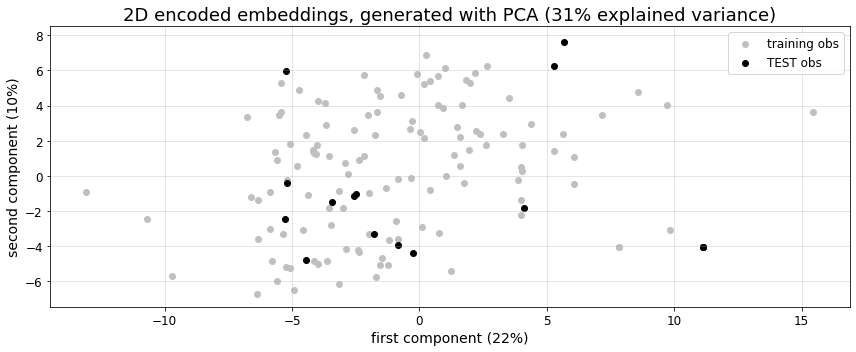

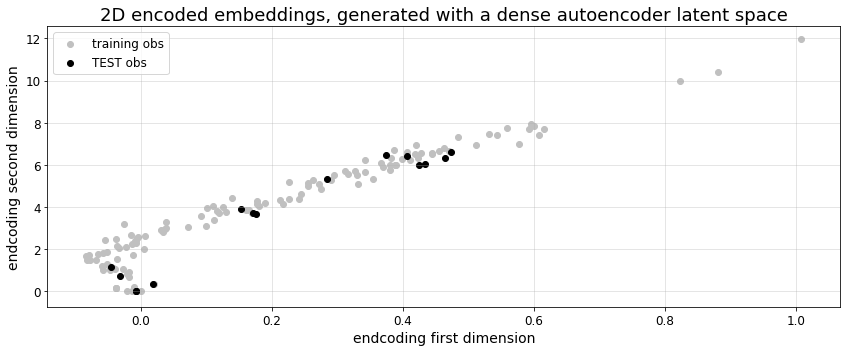

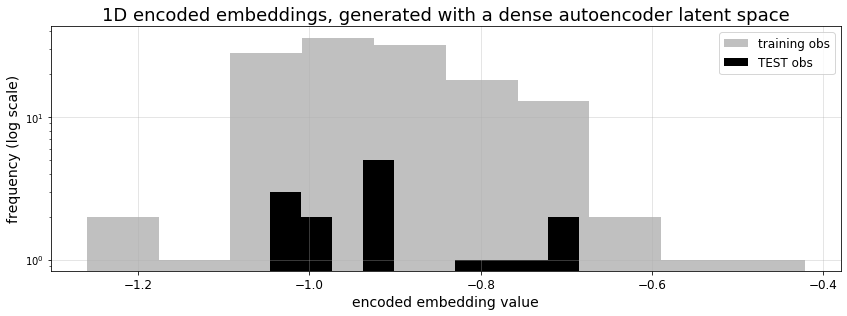

In [18]:
title = '2D encoded embeddings, generated with PCA '\
        '({:.0%} explained variance)'.format(total_expvar)
xlabel = 'first component ({:.0%})'.format(pca_expvar[0])
ylabel = 'second component ({:.0%})'.format(pca_expvar[1])

plot_2d_embed_scatter(pca_embed_train, pca_embed_test, title, xlabel, ylabel)

title = '2D encoded embeddings, generated with a dense autoencoder latent space'
xlabel = 'endcoding first dimension'
ylabel = 'endcoding second dimension'

plot_2d_embed_scatter(ae2_latent_train, ae2_latent_test, title, xlabel, ylabel)

title = '1D encoded embeddings, generated with a dense autoencoder latent space'
xlabel = 'encoded embedding value'

plot_1d_embed_hist(ae1_latent_train, ae1_latent_test, title, xlabel, logscale=True)

# Save resulting autoencoder models and fitted PCA model 